In [60]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# ETF list
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS', 'PSQ', 'VNQ', 'SPY'
]

# Date range: from 10 years ago to now
today = datetime.today()
back_time = today - timedelta(weeks=52 * 10)
start_date = back_time.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

print(f"🗕️ Downloading weekly data from {start_date} to {end_date}")

# Ensure dataset/ exists
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
os.makedirs(dataset_path, exist_ok=True)

# Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# Download each ETF
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(
        symbol,
        start=start_date,
        end=end_date,
        interval='1wk',  # back to Yahoo's default weekly format (week ending on Friday)
        auto_adjust=False,
        progress=False
    )
    if not data.empty:
        data = data[~data.index.duplicated(keep='first')].sort_index()
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# Merge and save
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    path = os.path.join(dataset_path, filename)
    df.to_csv(path)
    print(f"✅ Saved: {filename}")
    return df

# Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# Preview
price_df.head()


🗕️ Downloading weekly data from 2015-05-02 to 2025-04-19
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLRE...
⬇️ Downloading XLU...
⬇️ Downloading XLB...
⬇️ Downloading XLC...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading JETS...
⬇️ Downloading PSQ...
⬇️ Downloading VNQ...
⬇️ Downloading SPY...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS,PSQ,VNQ,SPY
Ticker,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS,PSQ,VNQ,SPY
Date,,,,,,,,,,,,,,,,,,,,
2015-05-04,38.081726,16.607918,62.328011,54.583626,47.107689,68.427338,37.711849,NaN,31.769205,42.112522,NaN,28.441835,152.327713,78.749893,51.727150,54.787800,23.647640,237.650375,53.803017,178.051453
2015-05-11,38.329544,16.567669,63.015369,53.855938,47.548962,68.418419,38.156704,NaN,31.978443,42.063538,NaN,28.762249,151.599579,78.259254,51.239155,55.656296,23.714336,235.520889,54.210804,178.741379
2015-05-18,38.586201,16.674990,63.626335,53.542168,47.374107,68.731087,37.773201,NaN,32.158836,41.745052,NaN,29.208431,151.162735,78.329353,50.925449,55.633797,22.027941,233.476532,53.515568,179.204132
2015-05-25,38.382645,16.500591,63.592381,52.333805,46.466599,68.159332,37.420406,NaN,32.108334,41.328590,NaN,30.265490,152.400543,79.205505,51.125877,54.702286,22.008886,234.243179,52.907204,177.647583
2015-06-01,38.010948,16.628035,63.083263,51.853111,46.508217,68.355858,36.500046,NaN,30.823997,40.838619,NaN,29.474947,153.419937,79.906456,50.472305,54.378292,22.018415,235.776443,51.616951,176.494934


In [61]:
import os 
import yfinance as yf
import pandas as pd
from datetime import datetime

# Macro indicator tickers on Yahoo Finance
macro_tickers = {
    'VIX': '^VIX',               # Volatility Index
    '10Y_Yield': '^TNX',         # 10-Year Treasury Yield (multiply by 0.1)
    'USD_Index': 'DX-Y.NYB',     # U.S. Dollar Index (ICE Dollar Index)
    'WTI_Crude': 'CL=F'          # Crude Oil (WTI Futures)
}

# Align with ETF backtest window using back_time
start_date = back_time.strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"📊 Downloading macro data from {start_date} to {end_date}")

# Download weekly data
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"⬇️ Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        macro_data[name] = data[['Close']].rename(columns={'Close': name})

# Combine all macro indicators into one DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)

# Fix 10Y yield scale
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] = macro_df['10Y_Yield'] * 0.1

# Clean and format
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df.sort_index(inplace=True)
macro_df.dropna(inplace=True)

# Save to CSV
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))
macro_df.to_csv(macro_save_path)
print(f"✅ Macro indicators saved to: {macro_save_path}")

# Preview
macro_df.head()


📊 Downloading macro data from 2015-05-02 to 2025-04-19
⬇️ Downloading VIX (^VIX)...
⬇️ Downloading 10Y_Yield (^TNX)...
⬇️ Downloading USD_Index (DX-Y.NYB)...
⬇️ Downloading WTI_Crude (CL=F)...
✅ Macro indicators saved to: d:\CodingWorks\my_MLQT_project\Stock-Prediction-Models\dataset\macro_indicators_weekly.csv


Price,VIX,10Y_Yield,USD_Index,WTI_Crude
Ticker,^VIX,^TNX,DX-Y.NYB,CL=F
Date,,,,
2015-05-04,12.86,0.2150,94.790001,59.389999
2015-05-11,12.38,0.2141,93.139999,59.689999
2015-05-18,12.13,0.2215,96.010002,59.720001
2015-05-25,13.84,0.2095,96.910004,60.299999
2015-06-01,14.21,0.2402,96.309998,59.130001


In [62]:
import pandas as pd
import os
from ta import momentum, trend, volume

# === Paths ===
price_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_prices_weekly.csv'))
volume_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_volume_weekly.csv'))

# === Helper to load ETF CSVs ===
def load_etf_csv(path, name='[unknown]'):
    try:
        header_row = pd.read_csv(path, header=None, nrows=2)
        columns = header_row.iloc[1].tolist()[1:]
        df = pd.read_csv(path, skiprows=3, header=None)
        df = df.iloc[:, :len(columns) + 1]
        df.columns = ['Date'] + columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')
        df = df.apply(pd.to_numeric, errors='coerce')
        print(f"✅ Loaded {name} with {len(columns)} tickers")
        return df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        raise

# === Load data ===
price_df = load_etf_csv(price_path, name='ETF Prices')
volume_df = load_etf_csv(volume_path, name='ETF Volume')

# === Feature storage ===
features_all = []
skipped = []

# === Feature generation loop ===
for symbol in price_df.columns:
    if symbol not in volume_df.columns:
        print(f"⚠️ Skipping {symbol}: volume data missing.")
        skipped.append(symbol)
        continue

    df = pd.DataFrame(index=price_df.index)
    df['close'] = price_df[symbol]
    df['volume'] = volume_df[symbol]

    try:
        # === Return-based technical indicators ===
        df[f'{symbol}_ret_1w'] = df['close'].pct_change(1)
        df[f'{symbol}_ret_3w'] = df['close'].pct_change(3)
        df[f'{symbol}_ret_6w'] = df['close'].pct_change(6)

        high = df['close'].rolling(window=14).max()
        low = df['close'].rolling(window=14).min()
        df[f'{symbol}_stoch_k'] = 100 * (df['close'] - low) / (high - low)
        df[f'{symbol}_stoch_d'] = df[f'{symbol}_stoch_k'].rolling(window=3).mean()
        df[f'{symbol}_williams_r'] = -100 * (high - df['close']) / (high - low)

        df[f'{symbol}_cci'] = trend.cci(high=df['close'], low=df['close'], close=df['close'], window=20)
        df[f'{symbol}_rsi'] = momentum.rsi(df['close'], window=14)
        df[f'{symbol}_obv'] = volume.on_balance_volume(df['close'], df['volume'])

        df[f'{symbol}_macd'] = trend.macd(df['close'])
        df[f'{symbol}_macd_signal'] = trend.macd_signal(df['close'])
        df[f'{symbol}_macd_diff'] = trend.macd_diff(df['close'])

        # === Add price and volume percent change (variation) ===
        df[f'{symbol}_price_change'] = df['close'].pct_change(1)
        df[f'{symbol}_volume_change'] = df['volume'].pct_change(1)

        derived_cols = df.columns.difference(['close', 'volume'])
        feature_df = df[derived_cols].copy()

        features_all.append(feature_df)
        print(f"📈 {symbol}: {feature_df.dropna(how='all').shape[0]} valid rows")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        skipped.append(symbol)

# === Final merge ===
if len(features_all) == 0:
    raise ValueError("🛑 No valid ETF features generated.")

features_df = pd.concat(features_all, axis=1).sort_index()
features_df = features_df[~features_df.index.duplicated(keep='first')]

print("📀 Final feature shape:", features_df.shape)

# === Save to CSV ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
features_df.to_csv(os.path.join(base_dir, 'weekly_etf_tech_feature.csv'))
print(f"✅ Saved features to: weekly_etf_tech_feature.csv")

✅ Loaded ETF Prices with 20 tickers
✅ Loaded ETF Volume with 20 tickers
📈 XLK: 520 valid rows
📈 XLF: 520 valid rows
📈 XLV: 520 valid rows
📈 XLE: 520 valid rows
📈 XLI: 520 valid rows
📈 XLY: 520 valid rows
📈 XLP: 520 valid rows
📈 XLRE: 507 valid rows
📈 XLU: 520 valid rows
📈 XLB: 520 valid rows
📈 XLC: 507 valid rows
📈 SOXX: 520 valid rows
📈 SH: 520 valid rows
📈 DOG: 520 valid rows
📈 RWM: 520 valid rows
📈 ITA: 520 valid rows
📈 JETS: 520 valid rows
📈 PSQ: 520 valid rows
📈 VNQ: 520 valid rows
📈 SPY: 520 valid rows
📀 Final feature shape: (520, 280)
✅ Saved features to: weekly_etf_tech_feature.csv


In [63]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
feat_path = os.path.join(base_dir, 'weekly_etf_tech_feature.csv')
macro_path = os.path.join(base_dir, 'macro_indicators_weekly.csv')
price_path = os.path.join(base_dir, 'etf_prices_weekly.csv')
volume_path = os.path.join(base_dir, 'etf_volume_weekly.csv')

# === Load main features ===
feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)

# === Load and parse macro indicators ===
macro_raw = pd.read_csv(macro_path, header=None)
macro_start = macro_raw.index[macro_raw[0] == 'Price'].tolist()[0]
macro_cols = macro_raw.iloc[macro_start].tolist()
macro_df = pd.read_csv(macro_path, skiprows=macro_start + 1, header=None)
macro_df.columns = macro_cols
macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'
macro_df = macro_df.rename(columns={'Price': 'Date'}).set_index('Date')
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df = macro_df[~macro_df.index.duplicated()].sort_index()

# === Load ETF price and volume ===
ticker_row = pd.read_csv(price_path, header=None, nrows=2).iloc[1, 1:].tolist()
price_df = pd.read_csv(price_path, skiprows=3, header=None)
volume_df = pd.read_csv(volume_path, skiprows=3, header=None)

price_df = price_df.iloc[:, :len(ticker_row)+1]
price_df.columns = ['Date'] + ticker_row
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df = price_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

volume_df = volume_df.iloc[:, :len(ticker_row)+1]
volume_df.columns = ['Date'] + ticker_row
volume_df['Date'] = pd.to_datetime(volume_df['Date'])
volume_df = volume_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

# === Output Directory ===
norm_dir = os.path.join(base_dir, 'normalized_matrix')
os.makedirs(norm_dir, exist_ok=True)

# === Normalize & Save per ETF ===
scaler = StandardScaler()

for ticker in ticker_row:
    feat_cols = [col for col in feat_df.columns if col.startswith(f'{ticker}_')]
    if len(feat_cols) == 0:
        print(f"⚠️ No features found for {ticker}, skipping...")
        continue

    df = feat_df[feat_cols].copy()
    df.columns = [col.replace(f'{ticker}_', '') for col in df.columns]

    df['price'] = price_df[ticker].pct_change()
    df['volume'] = volume_df[ticker].pct_change()

    # === Merge with true macro indicators ===
    df = df.join(macro_df, how='left')

    # === Build missing mask BEFORE filling
    mask = df.isna().astype(float)

    # === Fill and normalize only technical + pct change features, not macro
    macro_cols = macro_df.columns
    norm_cols = df.columns.difference(macro_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols].fillna(0.0))
    df[macro_cols] = df[macro_cols].fillna(0.0)  # keep raw values for macro features

    # === Save
    df.to_csv(os.path.join(norm_dir, f'{ticker}_combined.csv'))
    mask.to_csv(os.path.join(norm_dir, f'{ticker}_mask.csv'))
    print(f"✅ Saved {ticker}: {df.shape[0]} rows, {df.shape[1]} features")


✅ Saved XLK: 520 rows, 20 features


C:\Users\user\AppData\Local\Temp\ipykernel_7784\2028834899.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'


✅ Saved XLF: 520 rows, 20 features
✅ Saved XLV: 520 rows, 20 features
✅ Saved XLE: 520 rows, 20 features
✅ Saved XLI: 520 rows, 20 features
✅ Saved XLY: 520 rows, 20 features
✅ Saved XLP: 520 rows, 20 features
✅ Saved XLRE: 520 rows, 20 features
✅ Saved XLU: 520 rows, 20 features
✅ Saved XLB: 520 rows, 20 features
✅ Saved XLC: 520 rows, 20 features
✅ Saved SOXX: 520 rows, 20 features
✅ Saved SH: 520 rows, 20 features
✅ Saved DOG: 520 rows, 20 features
✅ Saved RWM: 520 rows, 20 features
✅ Saved ITA: 520 rows, 20 features
✅ Saved JETS: 520 rows, 20 features
✅ Saved PSQ: 520 rows, 20 features
✅ Saved VNQ: 520 rows, 20 features
✅ Saved SPY: 520 rows, 20 features


# start training

In [64]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))


# === Dataset ===
class ETFDataset(Dataset):
    def __init__(self, combined_csv, mask_csv):
        self.X = pd.read_csv(combined_csv, index_col=0).values.astype(np.float32)
        self.M = pd.read_csv(mask_csv, index_col=0).values.astype(np.float32)
        self.y = self.X[1:, 0]  # assume target is 1-week return (first col), shifted
        self.X = self.X[:-1]
        self.M = self.M[:-1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx]),
            torch.tensor(self.M[idx]),
            torch.tensor(self.y[idx])
        )

# === Model ===
class DualTransformerModel(nn.Module):
    def __init__(self, num_features, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=num_features,
                nhead=nhead,
                dim_feedforward=hidden_dim,
                batch_first=True  # 👈 this avoids the warning
            ),

            num_layers=num_layers
        )
        self.output = nn.Linear(num_features, 1)

    def forward(self, x, mask):
        x_masked = x * (1 - mask)  # mask==1 means missing
        x_seq = x_masked.unsqueeze(1)  # fake sequence length = 1
        enc = self.encoder(x_seq).squeeze(1)
        return self.output(enc).squeeze(-1)

# === Training Params ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
max_epochs = 500

# === Training Function ===
def train_one_etf(etf):
    print(f"\n🚀 Training {etf}")
    feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
    mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
    dataset = ETFDataset(feat_path, mask_path)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    X, _, _ = next(iter(loader))
    model = DualTransformerModel(num_features=X.shape[-1]).to(device)
    model.device = device  # Ensure we store the device inside the model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    best_models = []

    for epoch in range(max_epochs):
        model.train()
        total_loss, total_mae, total_win = 0, 0, 0

        for X, M, y in loader:
            X, M, y = X.to(model.device), M.to(model.device), y.to(model.device)
            pred = model(X, M)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mae = (pred - y).abs().mean().item()
            win = (torch.sign(pred) == torch.sign(y)).float().mean().item()
            total_loss += loss.item()
            total_mae += mae
            total_win += win

        avg_loss = total_loss / len(loader)
        avg_mae = total_mae / len(loader)
        avg_win = total_win / len(loader)
        score = avg_win * 0.6 + (1 - avg_mae) * 0.4
        best_models.append((score, model.state_dict(), avg_win, avg_mae))

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, MAE={avg_mae:.4f}, WinRate={avg_win:.4f}")

    # Save top 5 models
    top5 = sorted(best_models, key=lambda x: -x[0])[:5]
    weight_sum = sum(x[0] for x in top5)
    for i, (score, weights, win, mae) in enumerate(top5):
        out = {
            'weights': weights,
            'score': score,
            'win_rate': win,
            'mae': mae,
            'weight': score / weight_sum
        }
        save_path = os.path.join("..", "model_weights", f"{etf}_top{i+1}.pt")
        torch.save(out, save_path)

# === Execute ===
for etf in etf_list:
    train_one_etf(etf)


🚀 Training XLK
Epoch 100: Loss=0.3282, MAE=0.4417, WinRate=0.8327
Epoch 200: Loss=0.2708, MAE=0.4034, WinRate=0.8493
Epoch 300: Loss=0.2872, MAE=0.4180, WinRate=0.8548
Epoch 400: Loss=0.2668, MAE=0.3973, WinRate=0.8548
Epoch 500: Loss=0.2224, MAE=0.3659, WinRate=0.8750

🚀 Training XLF
Epoch 100: Loss=0.3918, MAE=0.4575, WinRate=0.8133
Epoch 200: Loss=0.3366, MAE=0.4222, WinRate=0.8280
Epoch 300: Loss=0.3048, MAE=0.4020, WinRate=0.8464
Epoch 400: Loss=0.2905, MAE=0.3937, WinRate=0.8556
Epoch 500: Loss=0.2641, MAE=0.3805, WinRate=0.8548

🚀 Training XLV
Epoch 100: Loss=0.3614, MAE=0.4527, WinRate=0.7965
Epoch 200: Loss=0.3292, MAE=0.4393, WinRate=0.8104
Epoch 300: Loss=0.3028, MAE=0.4163, WinRate=0.8269
Epoch 400: Loss=0.3069, MAE=0.4288, WinRate=0.8002
Epoch 500: Loss=0.2271, MAE=0.3612, WinRate=0.8398

🚀 Training XLE
Epoch 100: Loss=0.3566, MAE=0.4436, WinRate=0.8480
Epoch 200: Loss=0.3313, MAE=0.4134, WinRate=0.8269
Epoch 300: Loss=0.2920, MAE=0.3852, WinRate=0.8416
Epoch 400: Loss=0.

C:\Users\user\AppData\Local\Temp\ipykernel_7784\4081813117.py:43: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\anaconda3\envs\stock_cuda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


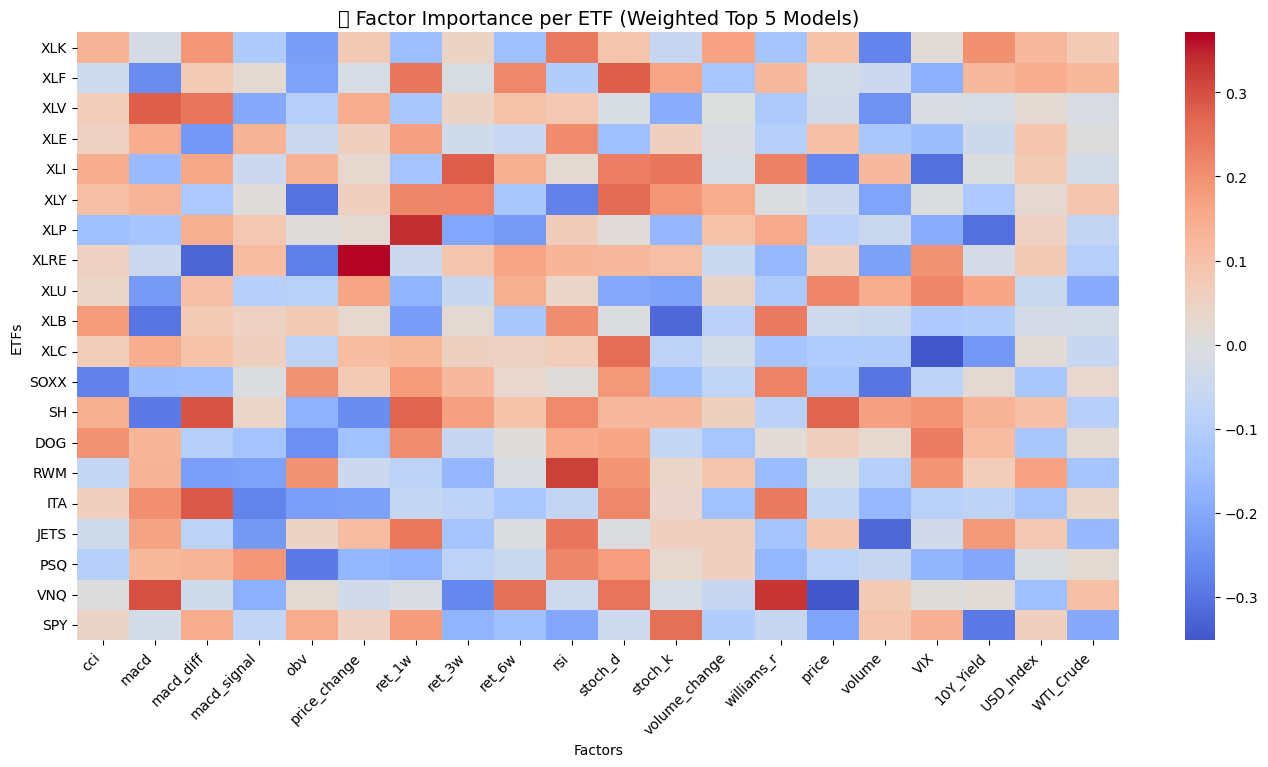

In [65]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
weights_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
feature_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))


# === Storage ===
factor_weights = {}

# === Extract input dimension ===
first_etf = etf_list[0]
example_path = os.path.join(feature_dir, f'{first_etf}_combined.csv')
example_features = pd.read_csv(example_path, index_col=0)
factor_names = example_features.columns.tolist()

# === Aggregate top 5 weights for each ETF
for etf in etf_list:
    weights = []
    for i in range(1, 6):
        model_path = os.path.join(weights_dir, f"{etf}_top{i}.pt")
        if os.path.exists(model_path):
            data = torch.load(model_path, map_location='cpu')
            linear_weights = data['weights']['output.weight'].squeeze().numpy()
            weights.append(linear_weights * data['weight'])  # weighted by performance
    if weights:
        factor_weights[etf] = sum(weights)

# === Create DataFrame for heatmap
weight_df = pd.DataFrame(factor_weights, index=factor_names)
weight_df = weight_df.T  # shape: (ETF, Factors)

# === Plot ===
plt.figure(figsize=(14, 8))
sns.heatmap(weight_df, cmap="coolwarm", annot=False, center=0)
plt.title("🎯 Factor Importance per ETF (Weighted Top 5 Models)", fontsize=14)
plt.xlabel("Factors")
plt.ylabel("ETFs")
plt.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()


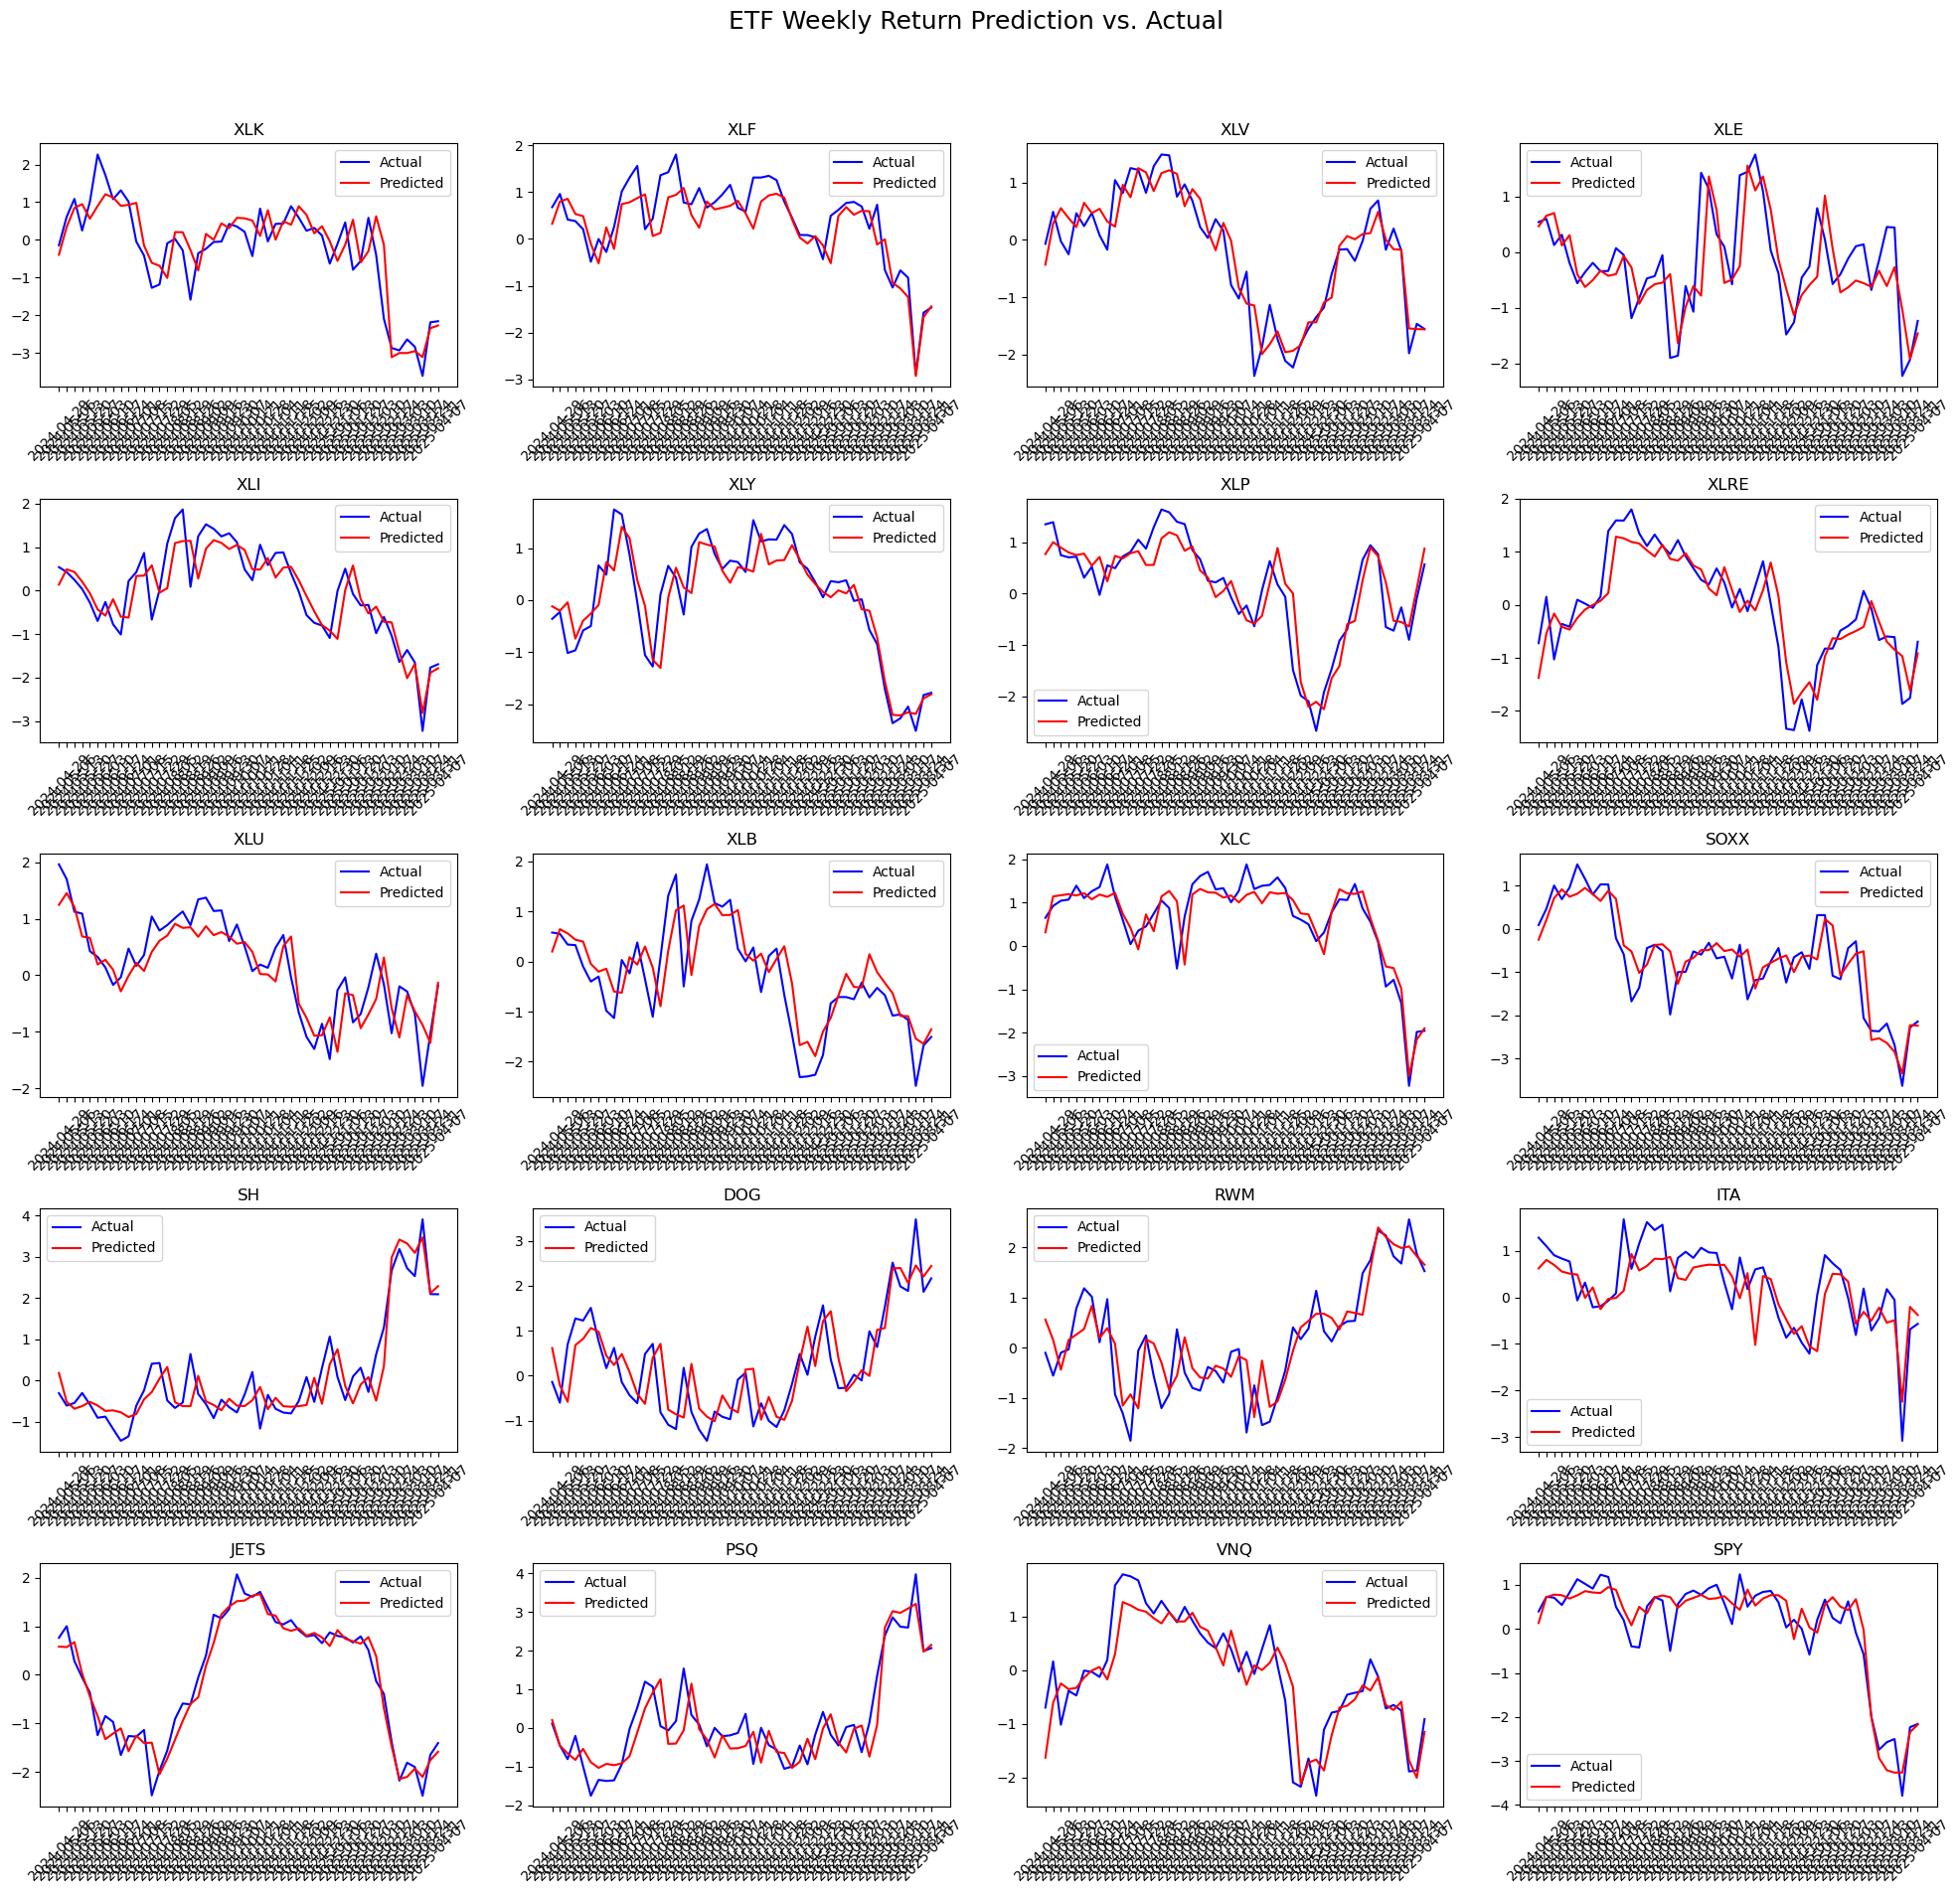

In [66]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.gridspec as gridspec

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))



# === Gather predictions
plot_data = []


for etf in etf_list:
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
        model_path = os.path.join(model_dir, f"{etf}_top1.pt")

        X = pd.read_csv(feat_path, index_col=0).astype('float32')
        M = pd.read_csv(mask_path, index_col=0).astype('float32')
        y = X.iloc[1:, 0].values
        X = X.iloc[:-1]
        M = M.iloc[:-1]

        model = DualTransformerModel(num_features=X.shape[1])
        model.load_state_dict(torch.load(model_path)['weights'])
        model.eval()

        with torch.no_grad():
            pred = model(torch.tensor(X.values), torch.tensor(M.values)).numpy()

        df = pd.DataFrame({'Date': X.index, 'Predicted': pred, 'Actual': y}).set_index('Date')
        plot_data.append((etf, df.iloc[-50:]))

    except Exception as e:
        print(f"⚠️ Error loading/predicting {etf}: {e}")

# === Plotting
fig = plt.figure(figsize=(20, 4 * ((len(plot_data) + 3) // 4)))
gs = gridspec.GridSpec((len(plot_data) + 3) // 4, 4, figure=fig)

for i, (etf, df) in enumerate(plot_data):
    ax = fig.add_subplot(gs[i])
    ax.plot(df.index, df['Actual'], label='Actual', color='blue')
    ax.plot(df.index, df['Predicted'], label='Predicted', color='red')
    ax.set_title(etf)
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("ETF Weekly Return Prediction vs. Actual", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [67]:
import os
import pandas as pd
import torch
import numpy as np
from datetime import datetime, timedelta

# === Prediction Class ===
class WeeklyETFPredictor:
    def __init__(self, model_dir, data_dir, record_dir, price_path, device=None):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.record_dir = record_dir
        self.price_path = price_path
        os.makedirs(self.record_dir, exist_ok=True)
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self):
        # Get nearest past Monday
        today = datetime.today()
        days_back = today.weekday() % 7
        monday = today - timedelta(days=days_back)
        monday_dt = pd.to_datetime(monday.strftime("%Y-%m-%d"))
        date_str = monday_dt.strftime("%Y-%m-%d")

        # Load ETF price data for actual price reference
        price_df = pd.read_csv(
            self.price_path,
            index_col=0,
            parse_dates=True,
            date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d", errors='coerce')
        )
        price_df = price_df[price_df.index.notna()]
        price_df = price_df[~price_df.index.duplicated()].sort_index()

        print(f"🔍 Available price dates: {price_df.index[-5:].to_list()}")
        print(f"📅 Looking for Monday: {monday_dt}")

        summary = []

        for fname in os.listdir(self.data_dir):
            if not fname.endswith("_combined.csv"): continue
            etf = fname.replace("_combined.csv", "")

            feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
            mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")

            try:
                df_feat = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                df_mask = pd.read_csv(mask_path, index_col=0, parse_dates=True)
            except Exception as e:
                print(f"❌ Failed to load data for {etf}: {e}")
                continue

            if monday_dt not in df_feat.index:
                print(f"⚠️ Missing feature/mask data for {etf} on {monday_dt.date()}")
                continue

            if etf not in price_df.columns:
                print(f"⚠️ ETF {etf} not found in price_df columns.")
                continue

            if monday_dt not in price_df.index:
                print(f"⚠️ Missing price for {etf} on {monday_dt.date()}")
                continue

            try:
                x_real = torch.tensor(df_feat.loc[monday_dt].values.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(df_mask.loc[monday_dt].values.astype(np.float32)).unsqueeze(0).to(self.device)
            except Exception as e:
                print(f"❌ Tensor conversion failed for {etf}: {e}")
                continue

            try:
                price = float(price_df.loc[monday_dt, etf])
            except Exception as e:
                print(f"⚠️ Price parsing error for {etf} on {monday_dt.date()}: {e}")
                price = None

            scores, preds, maes, winrates = [], [], [], []
            for i in range(1, 6):
                path = os.path.join(self.model_dir, f"{etf}_top{i}.pt")
                if not os.path.exists(path): continue
                try:
                    checkpoint = torch.load(path, map_location=self.device)
                    model = DualTransformerModel(num_features=x_real.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_real, x_mask).item()
                    preds.append(pred)
                    maes.append(checkpoint['mae'])
                    winrates.append(checkpoint['win_rate'])
                    scores.append(checkpoint['weight'])
                except Exception as e:
                    print(f"❌ Model loading/prediction failed for {etf} top{i}: {e}")

            if len(preds) == 0:
                print(f"⚠️ No predictions available for {etf}")
                continue

            pred_return = sum(p * w for p, w in zip(preds, scores))
            avg_mae = sum(maes) / len(maes)
            avg_win = sum(winrates) / len(winrates)

            if price is not None:
                if pred_return >= 0:
                    target_up = round(price * (1 + pred_return/100 + pred_return*avg_mae/100), 2)
                    stop_down = round(price * (1 - pred_return*avg_mae/100), 2)
                    buy_price = round(price, 2)
                else:
                    target_up = stop_down = buy_price = "X"
            else:
                target_up = stop_down = buy_price = "X"

            summary.append({
                'ETF': etf,
                'PredictedReturn': round(pred_return, 4),
                'MAE': round(avg_mae, 4),
                'WinRate': round(avg_win, 4),
                'BuyPrice': buy_price,
                'Target↑': target_up,
                'Stop↓': stop_down
            })

        summary_df = pd.DataFrame(summary)

        if summary_df.empty:
            print(f"⚠️ No prediction results available for {date_str}. Check model weights and input data.")
            return summary_df

        summary_df = summary_df.sort_values(by='PredictedReturn', ascending=False)

        # === Print to console
        print(f"\n📊 Weekly ETF Prediction Summary for {date_str}:")
        print(summary_df.to_string(index=False))

        # === Save to file
        output_path = os.path.join(self.record_dir, f"{today.strftime('%Y-%m-%d')}_predict_record.csv")
        summary_df.to_csv(output_path, index=False)
        print(f"📁 Prediction CSV saved to: {output_path}")
        return summary_df

# === Example usage ===
predictor = WeeklyETFPredictor(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    record_dir="../dataset/predict_record",
    price_path="../dataset/etf_prices_weekly.csv"
)
predictor.predict()


C:\Users\user\AppData\Local\Temp\ipykernel_7784\3237753605.py:26: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  price_df = pd.read_csv(


🔍 Available price dates: [Timestamp('2025-03-17 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-31 00:00:00'), Timestamp('2025-04-07 00:00:00'), Timestamp('2025-04-14 00:00:00')]
📅 Looking for Monday: 2025-04-14 00:00:00

📊 Weekly ETF Prediction Summary for 2025-04-14:
 ETF  PredictedReturn    MAE  WinRate BuyPrice Target↑  Stop↓
  SH           2.4731 0.3472   0.8860    46.75   48.31  46.35
 DOG           2.3748 0.3776   0.8794    28.75   29.69  28.49
 PSQ           1.8639 0.3732   0.8776    42.04   43.12  41.75
 RWM           1.4295 0.3500   0.8912    21.91   22.33   21.8
 XLP           0.9726 0.3381   0.8980    81.87   82.94   81.6
 XLU          -0.3002 0.3846   0.8654        X       X      X
 ITA          -0.3692 0.4121   0.8559        X       X      X
 XLE          -0.3946 0.3619   0.8776        X       X      X
XLRE          -0.5946 0.3755   0.8597        X       X      X
 VNQ          -0.8170 0.3618   0.8765        X       X      X
 XLF          -1.2560 0.3696   

,ETF,PredictedReturn,MAE,WinRate,BuyPrice,Target↑,Stop↓
5,SH,2.4731,0.3472,0.8860,46.75,48.31,46.35
0,DOG,2.3748,0.3776,0.8794,28.75,29.69,28.49
3,PSQ,1.8639,0.3732,0.8776,42.04,43.12,41.75
4,RWM,1.4295,0.3500,0.8912,21.91,22.33,21.8
15,XLP,0.9726,0.3381,0.8980,81.87,82.94,81.6
17,XLU,-0.3002,0.3846,0.8654,X,X,X
1,ITA,-0.3692,0.4121,0.8559,X,X,X
11,XLE,-0.3946,0.3619,0.8776,X,X,X
16,XLRE,-0.5946,0.3755,0.8597,X,X,X
8,VNQ,-0.8170,0.3618,0.8765,X,X,X


🔁 Loading price data...
📈 Loaded price data with 521 entries.
🔍 ETF list found: ['DOG', 'ITA', 'JETS', 'PSQ', 'RWM', 'SH', 'SOXX', 'SPY', 'VNQ', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

📅 Processing week: 2015-05-04 -> 2015-05-11


C:\Users\user\AppData\Local\Temp\ipykernel_7784\3149880970.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_df.index = pd.to_datetime(price_df.index, errors='coerce')



📅 Processing week: 2015-05-11 -> 2015-05-18

📅 Processing week: 2015-05-18 -> 2015-05-25

📅 Processing week: 2015-05-25 -> 2015-06-01

📅 Processing week: 2015-06-01 -> 2015-06-08

📅 Processing week: 2015-06-08 -> 2015-06-15

📅 Processing week: 2015-06-15 -> 2015-06-22

📅 Processing week: 2015-06-22 -> 2015-06-29

📅 Processing week: 2015-06-29 -> 2015-07-06

📅 Processing week: 2015-07-06 -> 2015-07-13

📅 Processing week: 2015-07-13 -> 2015-07-20

📅 Processing week: 2015-07-20 -> 2015-07-27

📅 Processing week: 2015-07-27 -> 2015-08-03

📅 Processing week: 2015-08-03 -> 2015-08-10

📅 Processing week: 2015-08-10 -> 2015-08-17

📅 Processing week: 2015-08-17 -> 2015-08-24

📅 Processing week: 2015-08-24 -> 2015-08-31

📅 Processing week: 2015-08-31 -> 2015-09-07

📅 Processing week: 2015-09-07 -> 2015-09-14

📅 Processing week: 2015-09-14 -> 2015-09-21

📅 Processing week: 2015-09-21 -> 2015-09-28

📅 Processing week: 2015-09-28 -> 2015-10-05

📅 Processing week: 2015-10-05 -> 2015-10-12

📅 Process

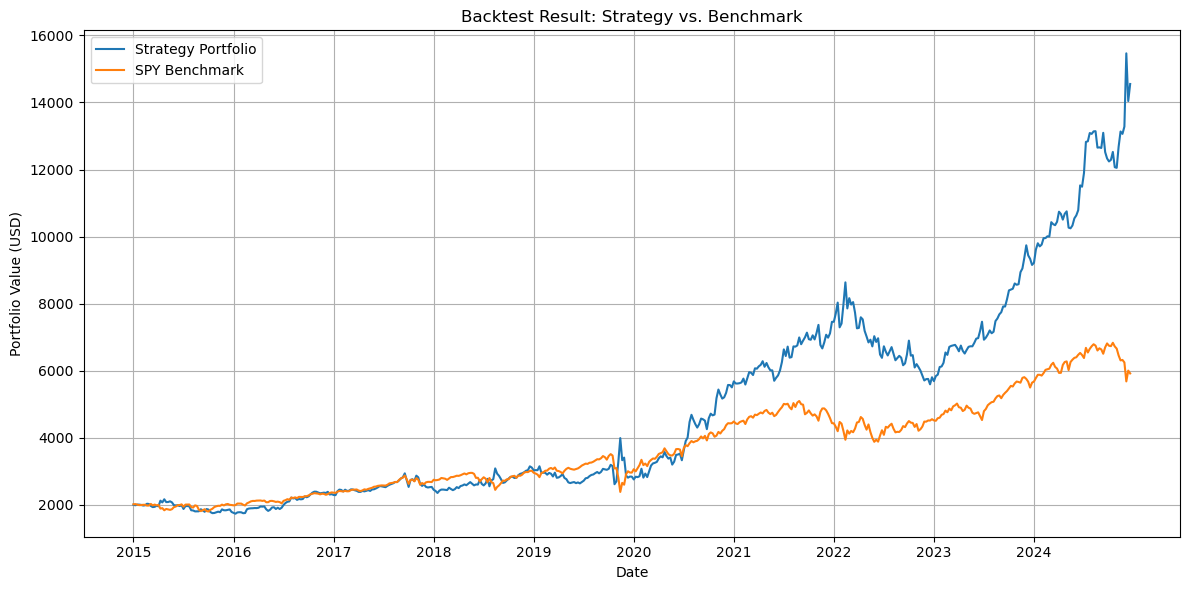


💰 Final Portfolio Value: $14,552.89
📈 Final Benchmark Value: $5,913.01
🎯 Strategy Return: 627.64%
📊 Benchmark Return: 195.65%


In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


class ETFBacktester:
    def __init__(self, model_dir, data_dir, price_path, initial_cash=2000, benchmark_symbol='SPY'):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.price_path = price_path
        self.initial_cash = initial_cash
        self.benchmark_symbol = benchmark_symbol
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def run(self):
        print("🔁 Loading price data...")
        price_df = pd.read_csv(self.price_path, index_col=0)
        price_df.index = pd.to_datetime(price_df.index, errors='coerce')
        price_df = price_df.apply(pd.to_numeric, errors='coerce')
        price_df = price_df[~price_df.index.duplicated()].sort_index()
        print(f"📈 Loaded price data with {len(price_df)} entries.")

        etf_list = [fname.replace('_combined.csv', '') for fname in os.listdir(self.data_dir) if fname.endswith('_combined.csv')]
        print(f"🔍 ETF list found: {etf_list}")

        cash = self.initial_cash
        holdings = {}
        portfolio_values = []
        benchmark_values = []
        dates = []
        trade_log = []
        value_log = []

        for i in range(len(price_df) - 2):
            date = price_df.index[i]
            next_date = price_df.index[i + 1]
            print(f"\n📅 Processing week: {date.date()} -> {next_date.date()}")

            # Sell all current holdings at the end of the week
            for etf, info in list(holdings.items()):
                if etf not in price_df.columns or next_date not in price_df.index:
                    continue
                try:
                    sell_price = float(price_df.loc[next_date, etf])
                except (KeyError, ValueError, TypeError):
                    continue
                shares = info['Shares']
                buy_price = info['BuyPrice']
                sell_value = shares * sell_price
                actual_return = (sell_price - buy_price) / buy_price
                predicted_return = info.get('PredictedReturn', None)
                cash += sell_value
                trade_log.append({
                    'Date': next_date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Sell',
                    'Price': sell_price,
                    'Shares': shares,
                    'Value': sell_value,
                    'BuyPrice': buy_price,
                    'PredictedReturn': predicted_return,
                    'ActualReturn': actual_return
                })
            holdings.clear()

            # Predict top 2 ETFs
            week_predictions = []
            for etf in etf_list:
                feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
                mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")
                if not os.path.exists(feat_path) or not os.path.exists(mask_path):
                    continue

                feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                mask_df = pd.read_csv(mask_path, index_col=0, parse_dates=True)
                if date not in feat_df.index:
                    continue

                x_real = torch.tensor(feat_df.loc[date].values.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(mask_df.loc[date].values.astype(np.float32)).unsqueeze(0).to(self.device)

                scores, preds = [], []
                for j in range(1, 6):
                    model_path = os.path.join(self.model_dir, f"{etf}_top{j}.pt")
                    if not os.path.exists(model_path): continue
                    checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)
                    model = DualTransformerModel(num_features=x_real.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_real, x_mask).item()
                    preds.append(pred)
                    scores.append(checkpoint['weight'])

                if preds:
                    pred_return = sum(p * w for p, w in zip(preds, scores))
                    try:
                        price = float(price_df.loc[date, etf]) if etf in price_df.columns else None
                    except (KeyError, ValueError, TypeError):
                        continue

                    if price is not None and not np.isnan(price):
                        week_predictions.append({
                            'ETF': etf,
                            'BuyPrice': price,
                            'PredictedReturn': float(pred_return)
                        })

            week_predictions = sorted(week_predictions, key=lambda x: -x['PredictedReturn'])[:2]

            for item in week_predictions:
                etf = item['ETF']
                price = item['BuyPrice']
                shares = int((cash / 2) // price)
                cost = shares * price
                if shares <= 0 or cost > cash:
                    continue
                cash -= cost
                holdings[etf] = {'Shares': shares, 'BuyPrice': price, 'PredictedReturn': item['PredictedReturn']}
                trade_log.append({
                    'Date': date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'PredictedReturn': item['PredictedReturn']
                })

            # Weekly portfolio valuation
            value = cash
            for etf, info in holdings.items():
                try:
                    price = float(price_df.loc[next_date, etf]) if etf in price_df.columns else 0
                except (KeyError, ValueError, TypeError):
                    price = 0
                value += info['Shares'] * price

            portfolio_values.append(value)
            dates.append(next_date.strftime('%Y-%m-%d'))
            value_log.append({
                'Date': next_date.strftime('%Y-%m-%d'),
                'Value': value,
                'Cash': cash,
                'Holdings': {k: dict(v) for k, v in holdings.items()}
            })

            if self.benchmark_symbol in price_df.columns:
                base_price = price_df[self.benchmark_symbol].iloc[0]
                current_price = price_df.loc[next_date, self.benchmark_symbol]
                benchmark_values.append(self.initial_cash * (current_price / base_price))
            else:
                benchmark_values.append(value)

        # Save logs
        result_df = pd.DataFrame({
            'Date': dates,
            'PortfolioValue': portfolio_values,
            'BenchmarkValue': benchmark_values
        })
        result_df['Date'] = pd.to_datetime(result_df['Date'], errors='coerce')
        result_df.set_index('Date', inplace=True)

        pd.DataFrame(trade_log).to_csv("../dataset/backtest_trade_log.csv", index=False)
        pd.DataFrame(value_log).to_csv("../dataset/backtest_value_log.csv", index=False)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(result_df['PortfolioValue'], label='Strategy Portfolio')
        plt.plot(result_df['BenchmarkValue'], label=f'{self.benchmark_symbol} Benchmark')
        plt.title("Backtest Result: Strategy vs. Benchmark")
        plt.ylabel("Portfolio Value (USD)")
        plt.xlabel("Date")

        xticks_idx = result_df.index[::52]
        xticks_labels = [str(d)[:4] if isinstance(d, str) else d.strftime('%Y') for d in xticks_idx]
        plt.xticks(xticks_idx, xticks_labels)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\n💰 Final Portfolio Value: ${result_df['PortfolioValue'].iloc[-1]:,.2f}")
        print(f"📈 Final Benchmark Value: ${result_df['BenchmarkValue'].iloc[-1]:,.2f}")
        print(f"🎯 Strategy Return: {((result_df['PortfolioValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")
        print(f"📊 Benchmark Return: {((result_df['BenchmarkValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")

        return result_df


    
    
# === Run the backtest
backtester = ETFBacktester(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    price_path="../dataset/etf_prices_weekly.csv",
    initial_cash=2000,
    benchmark_symbol="SPY"
)

# Execute the backtest logic
result_df = backtester.run()

